# 時系列データのベイズ分析

ベクトルや行列を太文字表記していないので要注意

In [1]:
# 必要なライブラリをインポート
import numpy as np
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## 時系列データと状態空間表現
時系列データの大きな特徴<br>
-> 現在の観測値の分布が過去の観測値に依存する（独立でない）

時点$t$の観測値を$y_t(t=1, \dotsc ,n)$とし，$y_{1:t}=(y_1, \dotsc ,y_t)$とまとめて表記する．<br>
このとき，$y_t$の分布が過去の観測値$y_{1: t-1}$に依存すると仮定すると，$y_{1:n}$の同時分布は以下の通り．
$$
    p(y_{1:n}|\theta) = p(y_1|\theta)p(y_2|y_1, \theta) \times \cdots \times p(y_n|y_{1:n-1}, \theta), \tag{1-1}
$$

時系列データ$y_{1:n}$の挙動を説明する最も基礎的な状態空間モデルは，以下の2つの式から構成される．
$$
    y_t = Z_t \alpha_t + \epsilon_t, \tag{1-2}
$$
$$
    \alpha_{t+1} = T_t \alpha_t + \eta_t, \tag{1-3}
$$

(1-2)式は**観測方程式**，(1-3)式は**状態方程式**と呼ばれる．

|変数|概要|次元|仮定|
|-|-|-|-|
|$y_t$|観測される時系列データ|$m \times 1$ベクトル|ー|
|$\alpha_t$|状態変数．観測されない確率変数|$r \times 1$ベクトル|$\alpha_1 \sim N_r(T_0\alpha_0, H_0H_0^T)$|
|$\epsilon_t$|観測方程式の誤差項|$m \times 1$ベクトル|$e_t=G_tu_t$|
|$\eta_t$|状態方程式の誤差項|$r \times 1$ベクトル|$\eta_t=H_tu_t$|
|$u_t$|観測されない確率変数|$l \times 1$ベクトル|$u_t \sim N_l(0,I)$|
|$Z_t$|ー|$m \times r$行列|ー|
|$G_t$|ー|$m \times l$行列|ー|
|$T_t$|ー|$r \times r$行列|ー|
|$H_t$|ー|$r \times l$行列|ー|

以上をまとめると状態空間モデルは以下の通りに書き直すことができる．
$$
    y_t = Z_t \alpha_t + G_t u_t, \tag{1-4} \\
    \alpha_{t+1} = T_t \alpha_t + H_t u_t, 
$$

さらに，$\{Z_t\}_{t=1}^n, \{G_t\}_{t=1}^n, \{T_t\}_{t=0}^n, \{H_t\}_{t=0}^n, \alpha_0$が全て既知であると仮定すると，(1-4)式における$\alpha_t$を所与としたときの$y_t$と$\alpha_{t+1}$の同時分布は以下の通りになる．
$$
    \begin{bmatrix}
        y_t \\ \alpha_{t+1}
    \end{bmatrix} \bigg| \alpha_t \sim
    N_{m+r} \bigg( 
        \begin{bmatrix}
            Z_t \alpha_t \\ T_t \alpha_t
        \end{bmatrix}, \ 
        \begin{bmatrix}
            G_tG_t^T && G_tH_t^T \\
            H_tG_t^T && H_tH_t^T
        \end{bmatrix}
    \bigg), \tag{1-5}
$$

## 状態空間モデルに関する推論
データ分析における状態空間モデルの主な利用法
1. フィルタリング: 時点$t$の状態変数$\alpha_t$の値を時点$t$までの時系列データ$y_{1:t}$に基づき推測すること
2. 予測: 将来の$\alpha_s$および$y_s(s>t)$の値を時点$t$までの時系列データ$y_{1:t}$に基づき推測すること
3. 平滑化: 観測されなかった過去の状態変数$\alpha_t(t=1, \dotsc , n)$の値を全標本期間のデータ$y_{1:n}$に基づき推測すること
4. パラメータの推定: 未知のパラメータを推定すること


### フィルタリング
フィルタリングのための事後分布は，**ベイズ・フィルター**というアルゴリズムで$p(\alpha_t|y_{1:t-1}), p(y_t|y_{1:t-1}), p(\alpha_t|y_{1:t})$を逐次的に求める．

事後分布$p(\alpha|y_{1:t})$はベイズの定理より以下の関係が成り立つ．
$$
    p(\alpha_t|y_{1:t}) = p(\alpha_t|y_t, y_{1:t-1}) 
    = \frac{p(y_t|alpha_t)p(\alpha_t|y_{1:t-1})}{p(y_t|y_{1:t-1})}, \tag{2-1}
$$
$$
    p(y_t|y_{1:t-1}) = \int_A p(y_t|\alpha_t)p(\alpha_t|y_{1:t-1})d\alpha_t, \tag{2-2}
$$
積分区間$A$は状態変数$\alpha_t$がとりうる値の集合．

さらに，$p(\alpha_t|y_{1:t})$と$p(\alpha_{t+1}|y_{1:t})$の間には以下の関係が成り立つ．
$$
    p(\alpha_{t+1}|y_{1:t}) = 
    \int_A p(\alpha_{t+1}| \alpha_t, y_{1:t}) p(\alpha_t|y_{1:t}) d\alpha_t, 
    \tag{2-3}
$$
(2-3)式を用いることで，時点$t$における$\alpha_t$の事後分布$p(\alpha_t|y_{1:t})$から時点$t+1$における$\alpha_{t+1}$の事前分布$p(\alpha_{t+1}|y_{1:t})$を導出できる．

(1-4)式で仮定されていた$\alpha_1 \sim N_r(T_0\alpha_0, H_0H_0^T)$を$\alpha_1$の$t=1$における事前分布とし，(2-1)~(2-3)式を繰り返し適用することで，$p(\alpha_t|y_{1:t-1}), p(y_t|y_{1:t-1}), p(\alpha_t|y_{1:t})$を逐次的に求めることができる．

> 特に$u_t$に正規分布を仮定している状態空間モデル(1-4)では，ベイズ・フィルターの(2-1)式と(2-3)式を解析的に評価することができ，**カルマン・フィルター**と呼ばれる．


### 予測
状態空間モデル(1-4)では$\alpha_{t+s}$が与えられると$y_{t+s}$と$y_{1:t}$が独立になることに注意すると，将来の$y_{t+s}(s \geq 1)$の値の予測分布は以下の通りになる．
$$
    p(y_{t+s}|y_{1:t}) = \int_A p(y_{t+s}|\alpha_{t+s})p(\alpha_{t+s}|y_{1:t})d\alpha_{t+s}, \tag{2-4}
$$
また，$p(\alpha_{t+s}|y_{1:t})$は以下のように与えることが知られている．
$$
    \alpha_{t+s}|y_{1:t} \sim N_k(\hat{\alpha}_t(s), P_t(s)), \tag{2-5}
$$
ここで，
$$
    \hat{\alpha}_t(s) =
        \begin{cases}
            \hat{\alpha}_{t+1} & (s=1) \\
            T_{t+s-1}\hat{\alpha_t}(s-1) & (s \geq 2)
        \end{cases}, 
$$
$$
    P_t(s) = 
        \begin{cases}
            P_{t+1} & (s=1) \\
            T_{t+s-1}P_t(s-1)P_{t+s-1}^T+H_{t+s-1}H_{t+s-1}^T & (s \geq 2)
        \end{cases}, 
$$
(2-5)式を用いると$y_{t+s}$の予測分布は以下のように導出される．
$$
    y_{t+s}|y_{1:t} \sim 
    N_m(Z_{t+s}\hat{\alpha}_t(s), Z_{t+s}P_t(s)Z_{t+s}^T + G_{t+s}G_{t+s}^T)
$$

### 平準化
平準化のための事後分布を考える．

$p(\alpha_t|y_{1:n})$と$p(\alpha_{t+1}|y_{1:n})$の間には以下の関係が成り立つ．
$$
    p(\alpha_t|y_{1:n}) = 
    \int_A p(\alpha_t| \alpha_{t+1}, y_t)p(\alpha_{t+1}|y_{1:n})d\alpha_{t+1}, 
    \tag{2-6}
$$
$p(\alpha_n|y_{1:n})$から始めて$t=n,n-1,\dotsc$と後ろ向きに(2-6)式を適用していけば，$p(\alpha_t|y_{1:n})$を逐次的に求めることができる．

また，状態空間モデル(1-4)では(2-6)式を解析的に評価することができ，これを**カルマン・スムーザー**と呼ぶ．


### パラメータの推定
パラメータ$\theta$の事前分布を$p(\theta)$とすると，状態空間モデル(1-4)の尤度は以下の通りに表すことができることが知られている．
$$
    p(y_{1:n}|\theta) = 
    p(y_1|\theta)\prod_{t=2}^Tp(y_t|y_{1:t-1}, \theta), 
    \tag{2-7}
$$
これにベイズの定理を適用すると，$\theta$の事後分布は以下のように与えられる．
$$
    p(\theta|y_{1:n}) \propto p(y_{1:n}|\theta)p(\theta), \tag{2-8}
$$
状態空間モデル(1-4)のように$u_i$が正規分布に従うときはカルマン・フィルターを適用でき，尤度(2-7)を解析的に導出することができる．

## PyMCによる状態空間モデルのベイズ分析

### ノイズを含むAR(1)過程
AR(1)過程
$$
    x_{t+1} = \rho x_t + \eta_t, \ 
    \eta_t \sim N(0, \omega^2), \ 
    t = 1, \dotsc , n-1, \tag{3-1}
$$
ただし，$|\rho|<1$と仮定し，$t=1$のときの$x_1$の分布を
$$
    x_1 \sim (0, \frac{\omega^2}{1-\rho^2}), \tag{3-2}
$$
とする．

さらに真の値$x_t$は観測されず，ノイズ$\epsilon_t$を含んだ値$y_t$のみが観測可能，すなわち，以下のように仮定する．
$$
    y_t = x_t + \epsilon_t, \
    \epsilon_t \sim N(0, \sigma^2), 
    \tag{3-3}
$$

真のモデルの設定
$$
    n=500, \sigma^2=0.25, \rho=0.9, \omega^2=0.19, 
$$

事前分布
$$
    \sigma \sim Ca^+(1.0), \ 
    \rho \sim U(-1, 1) \
    \omega \sim Ca^+(1.0), 
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, omega, rho, sigma]


/Users/s1ok69oo/my_study/nakatsuma_bayes_2019/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.514,0.030,0.459,0.572,0.000,0.000,4261.0,8142.0,1.0
rho,0.923,0.021,0.884,0.962,0.000,0.000,4967.0,8087.0,1.0
omega,0.408,0.038,0.339,0.479,0.001,0.001,2102.0,4183.0,1.0


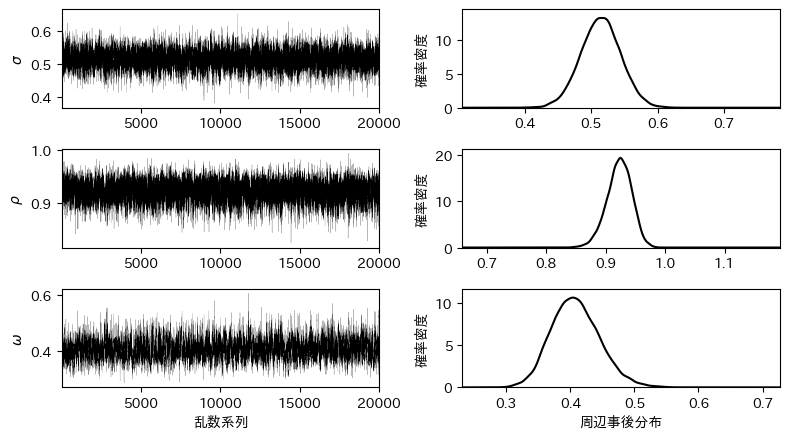

In [2]:
# 5.1: ノイズを含むAR(1)過程
# ノイズを含むAR(1)過程からデータを生成
n = 500
np.random.seed(99)
x = np.empty(n)
x[0] = st.norm.rvs() #定常分布の分散
for t in range(1, n):
    x[t] = 0.9*x[t-1] + st.norm.rvs(scale=np.sqrt(0.19))
y = x + st.norm.rvs(scale=0.5, size=n)

# 事後分布の設定
ar1_model = pm.Model()
with ar1_model:
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    rho = pm.Uniform('rho', lower=-1.0, upper=1.0)
    omega = pm.HalfCauchy('omega', beta=1.0)
    ar1 = pm.AR('ar1', rho, sd=omega, shape=n, 
                init=pm.Normal.dist(sd=omega/pm.math.sqrt(1-rho**2)))
    observation = pm.Normal('y', mu=ar1, sd=sigma, observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with ar1_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
param_names = ['sigma', 'rho', 'omega']
display(pm.summary(trace, var_names=param_names))

# 事後分布のグラフの作成
labels = ['$\\sigma$', '$\\rho$', '$\\omega$']
k = len(labels)
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace[param_names[idx]]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(labels[idx])
    ax[idx, 1].plot(x, posterior, 'k-')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
ax[k-1, 0].set_xlabel('乱数系列')
ax[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()

### 使用電力量のトレンドと季節変動


,使用電力量
1989年1月,51644033
1989年2月,47947215
1989年3月,48573850
1989年4月,48788188
1989年5月,46276002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [seasonal, trend, omega, tau, sigma]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.016,0.240,1.582,2.496,0.011,0.008,481.0,765.0,1.01
tau,0.294,0.170,0.068,0.601,0.012,0.008,193.0,353.0,1.03
omega,0.459,0.104,0.276,0.659,0.003,0.002,1133.0,2682.0,1.00


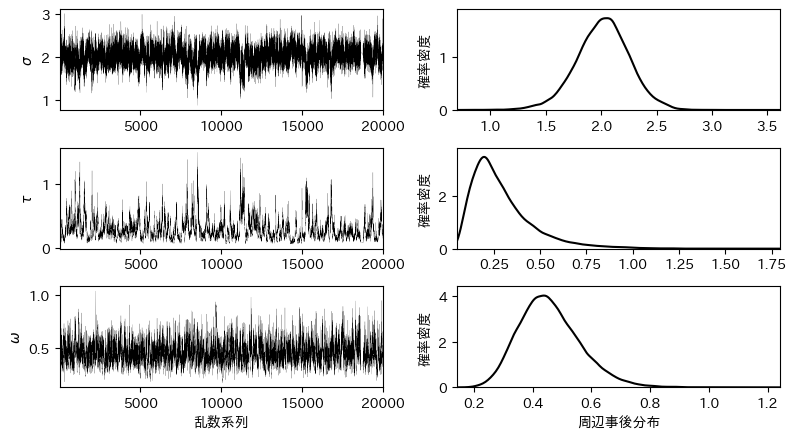

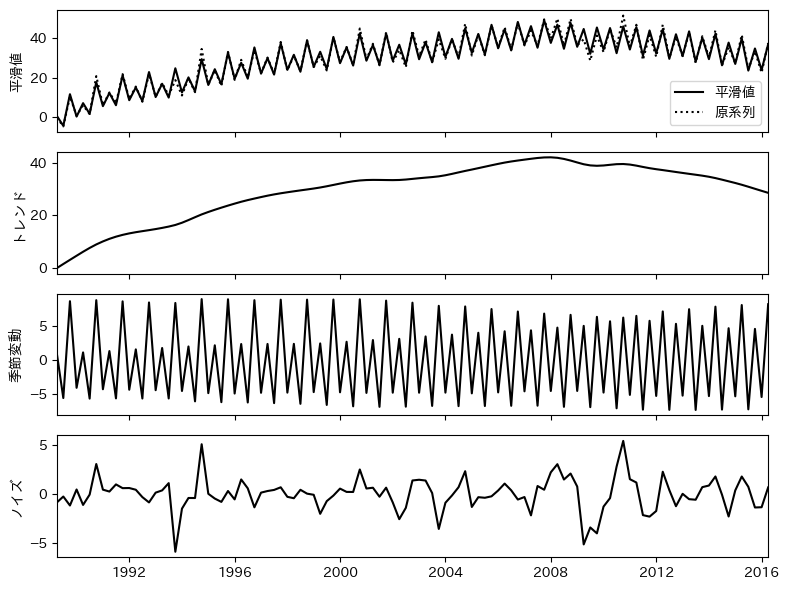

In [4]:
# 5.2: 使用電力量のトレンドと季節変動
# 使用電力量データの読み込み（本テキストのGithubページから取得）
path = 'https://raw.githubusercontent.com/nakatsuma/python_for_bayes/master/python/electricity.csv'
data = pd.read_csv(path, index_col=0)
display(data.head())
y0 = np.log(data.values.reshape((data.shape[0]//3, 3)).sum(axis=1))
y = 100 * (y0 - y0[0])
n = y.size
series_date = pd.date_range(start='1/1/1989', periods=n, freq='Q')

# 確率的トレンド+季節変動
trend_coef = np.array([2.0, -1.0])
seasonal_coef = np.array([-1.0, -1.0, -1.0])
timeseries_decomp = pm.Model()
with timeseries_decomp:
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    tau = pm.HalfCauchy('tau', beta=1.0)
    omega = pm.HalfCauchy('omega', beta=1.0)
    trend = pm.AR('trend', trend_coef, sd=tau, shape=n)
    seasonal = pm.AR('seasonal', seasonal_coef, sd=omega, shape=n)
    observation = pm.Normal('y', mu=trend+seasonal, sd=sigma, observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 2000
with timeseries_decomp:
    trace = pm.sample(
        draws=n_draws, 
        chains=n_chains, 
        tune=n_tune, 
        random_seed=123, 
        target_accept=0.9)
param_names = ['sigma', 'tau', 'omega']
display(pm.summary(trace, var_names=param_names))

# 事後分布のグラフの作成
series_name = ['原系列', '平滑値', 'トレンド', '季節変動', 'ノイズ']
labels = ['$\\sigma$', '$\\tau$', '$\\omega$']
k = len(labels)
fig1, ax1 = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace[param_names[idx]]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax1[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax1[idx, 0].set_xlim(1, n_draws*n_chains)
    ax1[idx, 0].set_ylabel(labels[idx])
    ax1[idx, 1].plot(x, posterior, 'k-')
    ax1[idx, 1].set_xlim(x_min, x_max)
    ax1[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax1[idx, 1].set_ylabel('確率密度')
ax1[k-1, 0].set_xlabel('乱数系列')
ax1[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()

# 時系列の分解
trend = trace['trend'].mean(axis=0)
seasonal = trace['seasonal'].mean(axis=0)
noise = y - trend - seasonal
series = np.vstack((y, trend+seasonal, trend, seasonal, noise)).T
results = pd.DataFrame(series, index=series_date, columns=series_name)
fig2, ax2 = plt.subplots(4, 1, sharex='col', num=2, figsize=(8, 6), facecolor='w')
for idx in range(4):
    ts_name = series_name[idx+1]
    ax2[idx].plot(results[ts_name], 'k-', label=ts_name)
    ax2[idx].set_ylabel(ts_name)
ax2[0].plot(results[series_name[0]], 'k:', label=series_name[0])
ax2[0].set_xlim(series_date[0], series_date[-1])
ax2[0].legend(loc='lower right')
plt.tight_layout()
plt.show()

### 確率的ボラティリティ・モデル

,JPY/USD
2014/1/2,104.86
2014/1/3,104.47
2014/1/6,104.40
2014/1/7,104.60
2014/1/8,104.89


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_vol, omega, rho, sigma, nu]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,7.300,1.937,4.280,10.859,0.029,0.021,4708.0,10593.0,1.00
sigma,0.463,0.081,0.324,0.601,0.003,0.002,1082.0,925.0,1.00
rho,0.982,0.010,0.964,0.999,0.001,0.001,166.0,367.0,1.03
omega,0.061,0.015,0.034,0.090,0.002,0.001,93.0,169.0,1.05


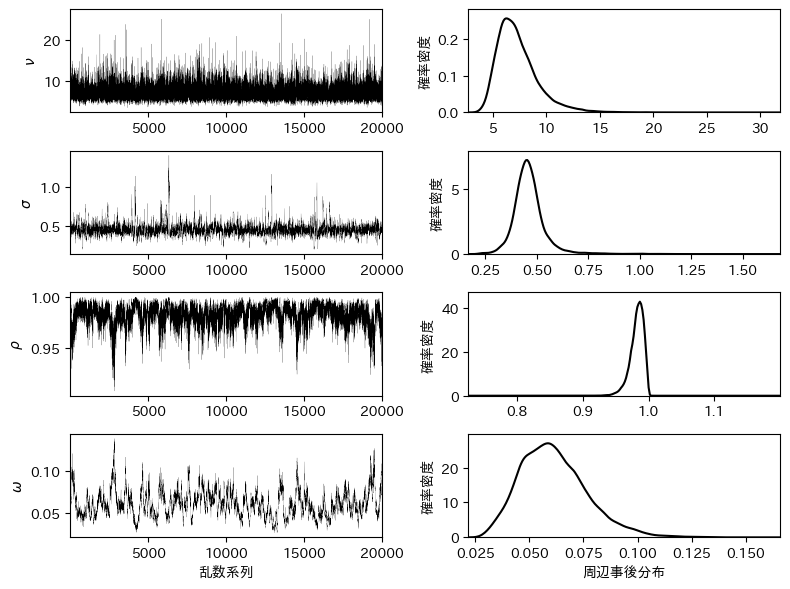

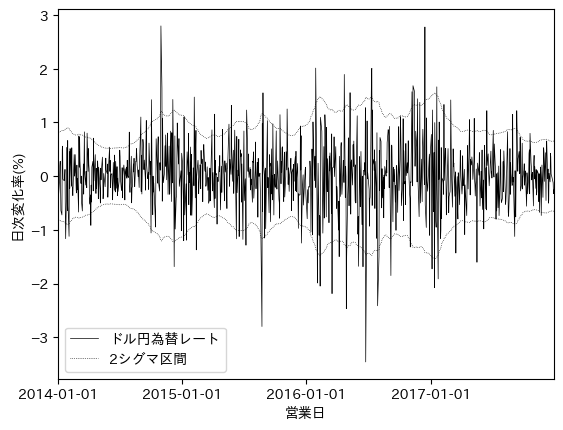

In [5]:
# 5.3: 確率的ボラティリティ・モデル
# ドル円為替レート日次データの読み込み（本テキストのGithubページから取得）
path = 'https://raw.githubusercontent.com/nakatsuma/python_for_bayes/master/python/dollaryen.csv'
data = pd.read_csv(path, index_col=0)
display(data.head())
y = 100 * np.diff(np.log(data.values.ravel()))
n = y.size
series_date = pd.to_datetime(data.index[1:])

# SVモデルの設定
sv_model = pm.Model()
with sv_model:
    nu = pm.Exponential('nu', 0.2)
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    rho = pm.Uniform('rho', lower=-1.0, upper=1.0)
    omega = pm.HalfCauchy('omega', beta=1.0)
    log_vol = pm.AR('log_vol', rho, sd=omega, shape=n, 
                    init=pm.Normal.dist(sd=omega/pm.math.sqrt(1-rho**2)))
    observation = pm.StudentT('y', nu, sd=sigma*pm.math.exp(log_vol), observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 2000
with sv_model:
    trace = pm.sample(draws=n_draws, 
                      chains=n_chains, 
                      tune=n_tune, 
                      random_seed=123, 
                      target_accept=0.9)
param_names = ['nu', 'sigma', 'rho', 'omega']
display(pm.summary(trace, var_names=param_names))

# 事後分布のグラフの作成
labels = ['$\\nu$', '$\\sigma$', '$\\rho$', '$\\omega$']
k = len(labels)
x_minimum = [3.0, 0.15, 0.9, 0.02]
x_maximum = [17.0, 0.85, 1.0, 0.16]
fig1, ax1 = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace[param_names[idx]]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax1[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax1[idx, 0].set_xlim(1, n_draws*n_chains)
    ax1[idx, 0].set_ylabel(labels[idx])
    ax1[idx, 1].plot(x, posterior, 'k-')
    ax1[idx, 1].set_xlim(x_min, x_max)
    ax1[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax1[idx, 1].set_ylabel('確率密度')
ax1[k-1, 0].set_xlabel('乱数系列')
ax1[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()

# ボラティリティのプロット
vol = np.median(np.tile(trace['sigma'], (n, 1)).T * np.exp(trace['log_vol']), axis=0)
fig2 = plt.figure(num=2)
plt.plot(series_date, y, 'k-', linewidth=0.5, label='ドル円為替レート')
plt.plot(series_date, 2.0*vol, 'k:', linewidth=0.5, label='2シグマ区間')
plt.plot(series_date, -2.0*vol, 'k:', linewidth=0.5)
plt.xlim(series_date[0], series_date[-1])
plt.xticks(['2014', '2015', '2016', '2017'])
plt.xlabel('営業日')
plt.ylabel('日次変化率(%)')
plt.legend(loc='best')
plt.show()